# Automated Feature Engineering for Predicting Remaining Useful Life

Predicting how long an engine, or any part for that matter, will last, is an incredibly important problem in engineering. Traditionally, companies have relied on manual inspection, which is error-prone and often can be inaccurate.

In this notebook, we will look at an automated approach to feature engineering for this time-series problem. We'll use Featurestools, the only open-source library for automated feature engineering to create a rich set of features in order to train machine learning models.

## Data

In the manual notebook, we defined the prediction problem by selecting Prediction Points in the data and then using the label as the number of weeks from this point to failure. The observational data was submitted to only periods from before this prediction point to ensure the data is valid. To make a fair comparison between manual and automated approaches, we'll load in the same exact data. 

The metric we establish is __Mean Absolute Percentage Error (MAPE)__, an interpretable measure that is the percentage error from our predictions. We'll measure MAPE both in 5-fold cross validation on the training data and on the test data (for which we know the true labels). Following are the various scores from manual feature engineering:

5-fold Cross Validation MAPE: 45.33
Test MAPE: 48.54.

## Roadmap

This is a fairly straightforward time-series problem once we have the data segmented into labels and allowable training data. Automated feature engineering is a series of steps using Featuretools

1. Create en EntitySet and add entities to it
    * Add dataframes and then normalize to create parent-child tables
2. Add relationships between Entities
    * When normalizing tables this is done automatically
3. Define custom primitives, interesting values, or seed features
4. Select primitives to use for deep feature synthesis
5. Run deep feature synthesis to create features

Along the way, we'll try out some of the more advanced aspects of Featuretools that can help us get the most from our results.


In [1]:
import pandas as pd
import numpy as np

import featuretools as ft
import featuretools.variable_types as vtypes

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

% load_ext autoreload
% autoreload 2
% aimport utils
from utils import feature_selection, plot_feature_importances, evaluate, random_search

In [2]:
train = pd.read_csv('../input/train_obs.csv').reset_index()
train.head()

,index,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,...,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time,time_in_cycles
0,0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,...,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,2010-01-01 00:10:00,1
1,1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,...,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2010-01-01 00:20:00,2
2,2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,...,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,2010-01-01 00:30:00,3
3,3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,...,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,2010-01-01 00:40:00,4
4,4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,...,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,2010-01-01 00:50:00,5


# EntitySet and Entities


First we'll define an EntitySet and add our entities to it.

In [3]:
es = ft.EntitySet(id = 'engines')

# Make an entity from the observations data
es = es.entity_from_dataframe(dataframe = train,
                              entity_id = 'obs',
                              index = 'index', 
                              time_index = 'time')

## Normalizing Data

In the manual engineering notebook, we created features by grouping and aggregating the observations for each engine and then creating a final table with one row for each engine. We'll do the same basic idea in Featuretools, but our method will be slightly different. First we'll _normlize_ the `obs` data by the engine. This will create a table with one row for each engine where the index is the `engine_no`. Then, when we build features our of the observational data, we can specify this table as where we want to build our features. This is done using `normalize_entity` with the following arguments:

* `base_entity_id`: the table where our new table is drawn from. In this case, the `obs` table because each engine is represented multiple times in this data
* `new_entity_id` the name given to the new table
* `index`: the unique identifier for the table. This is the `engine_no` because it is unique to each engine

### Relationships

Normally, we have to explicitly define the table relationships when using Featuretools, specifying the parent varialbe and the child  variable. However, when using `normalize_entity`, this is done for us for free! The function will add a relationship relative the `index` in the new entity to the `index` in the original entity.

In [4]:
# Create a new table with unique engines
es.normalize_entity(base_entity_id = 'obs',
                    new_entity_id = 'engines', 
                    index = 'engine_no')
es

Entityset: engines
  Entities:
    obs [Rows: 27403, Columns: 33]
    engines [Rows: 260, Columns: 2]
  Relationships:
    obs.engine_no -> engines.engine_no

And with that, we are good to go! We can run deep feature synthesis on our data right away and get started creating features.

# Deep Feature Synthesis and Feature Primitives

To understand deep feature synthesis (DFS), we first have to grasp feature primitives. A feature primitive a at a very high-level is an operation applied to data to create a feature. These represent very simple calculations that can be stacked on top of each other to create complex features. Feature primitives fall into two categories:

* __Aggregation__ (`agg`): function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
* __Transformation__ (`trans`): an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.

Deep feature synthesis takes feature primitives and stacks them on top of each other to create new features. The depth of a feature is the number of primitives, so, for example, taking the mean of a maximum would be a feature of depth 2. Because we only have two tables in this case, we'll stick to features with depth of 1. When doing manual engineering, all of the features we created were essentially "deep features" since we made them by aggregating child observations for each parent. Featuretools will do this for us in deep feature synthesis but with a clean interface. 

Let's take a look at a basic example of running deep feature synthesis using `ft.dfs`. We'll specify to build the features for each engine (`target_entity = engines`), list a few `agg` and `trans` primitives, a maximum depth of 1, and `n_jobs=-1` to run on all cores.

In [5]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='engines',
                                       agg_primitives = ['min', 'max', 'mean', 'count', 'sum', 'last'],
                                       trans_primitives = ['cum_mean', 'cum_sum'],
                                       max_depth = 1, n_jobs = -1, verbose = 1)
feature_matrix.head()

Built 151 features
EntitySet scattered to workers in 2.555 seconds
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,LAST(obs.sensor_measurement_25),LAST(obs.sensor_measurement_26),LAST(obs.sensor_measurement_3),LAST(obs.sensor_measurement_4),LAST(obs.sensor_measurement_5),LAST(obs.sensor_measurement_6),LAST(obs.sensor_measurement_7),LAST(obs.sensor_measurement_8),LAST(obs.sensor_measurement_9),LAST(obs.time_in_cycles)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,0.0,60.0,445.0,0.94,36.57,129.63,2027.94,7857.51,8.3892,...,NaN,NaN,1266.53,1061.97,7.05,9.03,175.01,1915.11,7998.70,119
2,0.0000,0.0,60.0,445.0,0.94,36.51,129.80,2028.29,7875.70,8.4025,...,NaN,NaN,1366.02,1129.00,5.48,8.00,194.14,2223.12,8362.80,142
3,0.0002,0.0,60.0,445.0,0.94,36.33,130.27,2028.18,7868.28,8.3688,...,NaN,NaN,1358.37,1124.09,3.91,5.72,138.58,2211.89,8317.17,80
4,0.0004,0.0,60.0,445.0,0.94,36.54,130.11,2028.23,7870.69,8.3926,...,NaN,NaN,1486.66,1255.54,9.35,13.66,334.59,2323.99,8730.81,80
5,0.0008,0.0,60.0,445.0,0.94,36.53,130.15,2028.30,7876.75,8.3771,...,NaN,NaN,1259.69,1043.76,7.05,9.03,175.49,1915.44,8014.78,32


# Modeling

We can directly use these features for modeling. First we'll want to apply the same operations to our test data. We can load in the test data and create a separate `EntitySet` (for this problem, a separate `EntitySet` is probably the easiest way to keep track of the training and testing information). 

In [6]:
test = pd.read_csv('../input/test_obs.csv').reset_index()
test_es = ft.EntitySet(id = 'test_engines')
test_es = test_es.entity_from_dataframe(dataframe = test,
                                        entity_id='obs', 
                                        index = 'index',
                                        time_index = 'time')

We'll want to normalize this table as well by each engine.

In [7]:
test_es.normalize_entity(base_entity_id='obs',
                         new_entity_id = 'engines', 
                         index = 'engine_no')
test_es

Entityset: test_engines
  Entities:
    obs [Rows: 33991, Columns: 33]
    engines [Rows: 259, Columns: 2]
  Relationships:
    obs.engine_no -> engines.engine_no

We already have the features we need to make, `feature_names`, so we don't need to run `ft.dfs` but instead can use `calculate_feature_matrix` passing the list of features. 

In [8]:
test_feature_matrix = ft.calculate_feature_matrix(feature_names, entityset=test_es, 
                                                   n_jobs = -1, verbose = 1)
test_feature_matrix.head()

EntitySet scattered to workers in 2.511 seconds
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,LAST(obs.sensor_measurement_25),LAST(obs.sensor_measurement_26),LAST(obs.sensor_measurement_3),LAST(obs.sensor_measurement_4),LAST(obs.sensor_measurement_5),LAST(obs.sensor_measurement_6),LAST(obs.sensor_measurement_7),LAST(obs.sensor_measurement_8),LAST(obs.sensor_measurement_9),LAST(obs.time_in_cycles)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0002,0.0,60.0,445.0,0.94,36.63,129.87,2027.98,7859.50,8.3979,...,NaN,NaN,1515.00,1325.07,10.52,15.50,393.58,2319.11,8826.49,258
2,0.0005,0.0,60.0,445.0,0.94,36.63,130.02,2028.17,7869.69,8.4109,...,NaN,NaN,1591.67,1418.17,14.62,21.61,553.36,2388.17,9056.17,55
3,0.0001,0.0,60.0,445.0,0.94,36.59,129.89,2028.06,7862.27,8.4025,...,NaN,NaN,1370.62,1135.59,5.48,8.00,194.58,2222.96,8353.33,165
4,0.0002,0.0,60.0,445.0,0.94,36.71,130.22,2028.20,7871.40,8.4160,...,NaN,NaN,1487.94,1257.49,9.35,13.66,334.39,2324.07,8733.15,86
5,0.0000,0.0,60.0,445.0,0.94,36.43,129.98,2028.23,7869.72,8.3882,...,NaN,NaN,1358.95,1140.34,3.91,5.72,138.42,2212.90,8391.57,148


In [9]:
# Load in the labels for training 
train_labels = np.array(pd.read_csv('../input/engines_4.csv')['label']).reshape((-1, ))
test_labels = np.array(pd.read_csv('../input/RUL_FD002.txt', sep=' ', 
                                   header=-1, names=['label'], index_col=False)['label']).reshape((-1, ))

### Feature Selection

We can use the `feature_selection` function previously developed in order to limit the amout of features (because some may be irrelevant or redudant). In the manual feature engineering notebook, we saw the importance of feature selection as it increased our score from no better than random guessing to extremely accurate.

In [10]:
feature_matrix = feature_selection(feature_matrix)
test_feature_matrix = test_feature_matrix[feature_matrix.columns]

Original shape:  (260, 151)
7  non-unique valued columns.
20 missing columns with threshold: 90.
10 zero variance columns.
72 collinear columns removed with threshold: 0.95.
Total columns removed:  109
Shape after feature selection: (260, 42).


In [11]:
preds, fi = evaluate(feature_matrix, train_labels, test_feature_matrix, test_labels)

5-fold CV MAPE: 46.40 with std: 5.77
Test MAPE: 50.38.


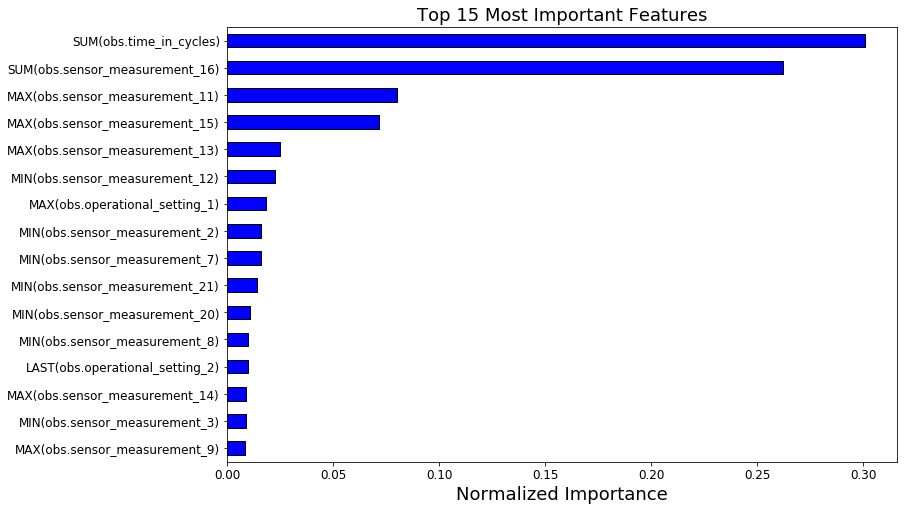

In [12]:
norm_fi = plot_feature_importances(fi)

Right out of the box, we see very good results from Automated Feature Engineering. Moreover, the most important feature makes intuitive sense: the total number of previous cycles is likely the most indicative indicator of when an engine will fail. We can also see that __Sensor Measurement 16__ is very important which could indicate to the engineers they should focus on this measure. 

## More Advanced Primitives

In the manual feature engineering notebook, we saw that performance improved when we included a number of advanced operations dealing with clustering and time-series. In this notebook we will not use the clustering methods, but will use the time-series methods by making custom primitives. 

In [13]:
from tsfresh.feature_extraction.feature_calculators import (cid_ce, number_peaks, 
                                                             last_location_of_maximum, 
                                                             skewness, sample_entropy)

import featuretools.variable_types as vtypes
from featuretools.primitives import make_agg_primitive

Each primitive we make is an `agg` because it takes multiple children observations and computes a single number. (A transform primitive acts on a single column and returns as many values as there are numbers in the column). 

Featuretools already sort entities by the `time_index` if provided with one, so the time-series operations will be applied to the data in the correct order. For each custom primitive we provide:

* The function. Here we use anonymous `lambda` functions but we could define them as complete functions.
* The input types accepted by the primitive. All of these time-series methods act on numbers so we limit the input types to `Numeric`.
* The return type of the function. These methods return a single `Numeric` number
* A name for the primitive

These parameters will change depending on the proble and the function. All of the custom primitives below are `agg` and take and return `Numeric` datatypes, but in theory custom primitives can have much wider applications. 

In [14]:
cid_ce_primitive = make_agg_primitive(lambda x: cid_ce(x , False),
                                      input_types = [vtypes.Numeric],
                                      return_type = vtypes.Numeric,
                                      name = 'Complexity')

number_peaks_primitive = make_agg_primitive(lambda x: number_peaks(x , 5),
                                            input_types = [vtypes.Numeric],
                                            return_type = vtypes.Numeric,
                                            name = 'NumberPeaks')

last_location_of_maximum_primititive = make_agg_primitive(lambda x: last_location_of_maximum(x),
                                                          input_types = [vtypes.Numeric],
                                                          return_type = vtypes.Numeric,
                                                          name = 'LastLocationMax')

skewness_primitive = make_agg_primitive(lambda x: skewness(x),
                                        input_types = [vtypes.Numeric],
                                        return_type = vtypes.Numeric,
                                        name = 'Skewness')

sample_entropy_primitive = make_agg_primitive(lambda x: sample_entropy(x),
                                              input_types = [vtypes.Numeric],
                                              return_type = vtypes.Numeric,
                                              name = 'Entropy')

Now we use the same `ft.dfs` call but add in the primitives we built. 

In [15]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='engines',
                                       agg_primitives = ['min', 'max', 'mean', 'count', 'sum', 'last',
                                                         cid_ce_primitive, number_peaks_primitive, 
                                                         last_location_of_maximum_primititive,
                                                         skewness_primitive, sample_entropy_primitive],
                                       trans_primitives = ['cum_mean', 'cum_sum'],
                                       max_depth = 1, n_jobs = -1, verbose = 1)
feature_matrix.head()

Built 301 features
EntitySet scattered to workers in 2.707 seconds
Elapsed: 01:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


,MIN(obs.operational_setting_1),MIN(obs.operational_setting_2),MIN(obs.operational_setting_3),MIN(obs.sensor_measurement_1),MIN(obs.sensor_measurement_10),MIN(obs.sensor_measurement_11),MIN(obs.sensor_measurement_12),MIN(obs.sensor_measurement_13),MIN(obs.sensor_measurement_14),MIN(obs.sensor_measurement_15),...,ENTROPY(obs.sensor_measurement_25),ENTROPY(obs.sensor_measurement_26),ENTROPY(obs.sensor_measurement_3),ENTROPY(obs.sensor_measurement_4),ENTROPY(obs.sensor_measurement_5),ENTROPY(obs.sensor_measurement_6),ENTROPY(obs.sensor_measurement_7),ENTROPY(obs.sensor_measurement_8),ENTROPY(obs.sensor_measurement_9),ENTROPY(obs.time_in_cycles)
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,0.0,60.0,445.0,0.94,36.57,129.63,2027.94,7857.51,8.3892,...,inf,inf,1.260269,1.297623,1.666739,1.450558,1.450558,1.215096,1.215096,2.315631
2,0.0000,0.0,60.0,445.0,0.94,36.51,129.80,2028.29,7875.70,8.4025,...,inf,inf,1.317122,1.452252,1.765438,1.540545,1.540545,1.285559,1.285921,2.208374
3,0.0002,0.0,60.0,445.0,0.94,36.33,130.27,2028.18,7868.28,8.3688,...,inf,inf,1.203973,1.333294,1.714447,1.714447,1.505819,1.114240,1.161633,2.321755
4,0.0004,0.0,60.0,445.0,0.94,36.54,130.11,2028.23,7870.69,8.3926,...,inf,inf,1.261504,1.405464,1.716206,1.596859,1.596859,1.212447,1.227453,2.321755
5,0.0008,0.0,60.0,445.0,0.94,36.53,130.15,2028.30,7876.75,8.3771,...,inf,inf,1.386294,1.581603,1.929910,1.581603,1.581603,1.339041,1.354546,2.772589


In [16]:
test_feature_matrix = ft.calculate_feature_matrix(entityset=test_es, 
                                                  features=feature_names,
                                                  n_jobs = -1, verbose = 1)

# Apply feature selection
feature_matrix = feature_selection(feature_matrix)
test_feature_matrix = test_feature_matrix[feature_matrix.columns]

EntitySet scattered to workers in 2.602 seconds
Elapsed: 01:11 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Original shape:  (260, 301)
41  non-unique valued columns.
25 missing columns with threshold: 90.
11 zero variance columns.
144 collinear columns removed with threshold: 0.95.
Total columns removed:  221
Shape after feature selection: (260, 80).


### Evaluate Custom Primitive Features

We'll take the enriched and selected set of features and `evaluate` them. Then we can look at the feature importances to see if any of the time-series custom primitives were of use. 

5-fold CV MAPE: 44.64 with std: 5.52
Test MAPE: 48.79.


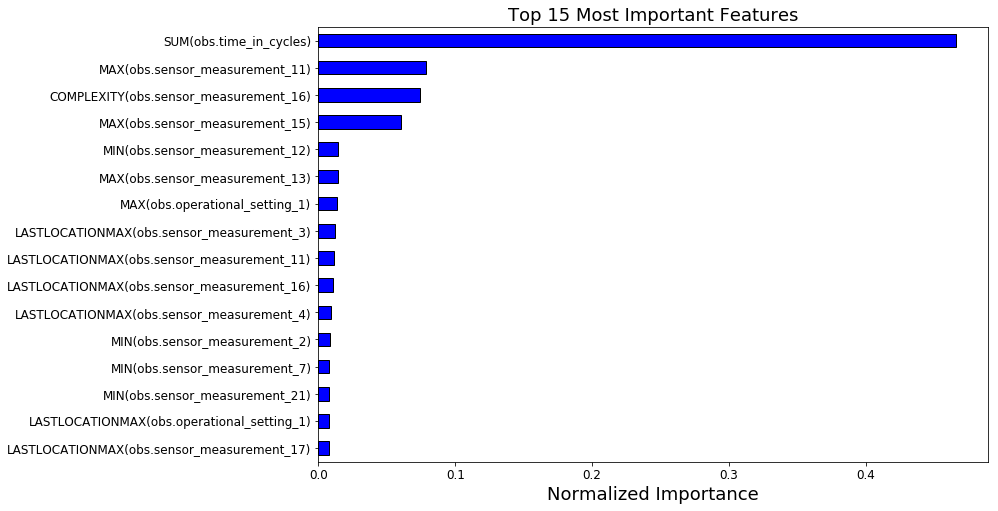

In [17]:
preds, fi = evaluate(feature_matrix, train_labels, test_feature_matrix, test_labels)
norm_fi = plot_feature_importances(fi)

The last location of maximum value seems to be relatively important. We also see the Complexity of Sensor Measurement 16 in the top 3 most important features reflecting our finding in the manual feature engineering that this sensor measurement was among the most meaningful. As with the manual feature engineering, by far the most important feature is derived from the time in cycles, a direct measurement of the time the engine has been running. 

## Random Search

The final step, just as with manual feature engineering, is to optimize the Random Forest model for our dataset. This will be done with 100 iterations of random search using 5-fold cross validation.

In [18]:
best_model = random_search(feature_matrix, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min finished


Best 5-fold CV Score: 44.30 with std: 5.21.

Best Hyperparameters:
{'n_estimators': 50, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 5}


In [19]:
from sklearn.preprocessing import Imputer

# Impute the missing values
imputer = Imputer(strategy = 'median', axis = 1)
train = imputer.fit_transform(feature_matrix.replace({np.inf:np.nan}))
test = imputer.transform(test_feature_matrix.replace({np.inf:np.nan}))

In [20]:
predictions = best_model.predict(test)
final_mape = 100 * np.mean(abs(predictions - test_labels) / test_labels)
print('Final Test MAPE: {:.2f}.'.format(final_mape))

Final Test MAPE: 50.01.


In [21]:
# fi = pd.DataFrame({'feature': feature_matrix.columns,
#                    'importance': best_model.feature_importances_})
# norm_fi = plot_feature_importances(fi)

## Just for Fun: Dimensionality Reduction with UMAP

As a slight diversion, we can use UMAP on the final dataset to see if there is a clean separation of engines in terms of the labels. We'll use UMAP to reduce the number of dimensions from 80 to three, and then visualize the matrix colored by the label.